In [2]:
%load_ext autoreload
%autoreload 2
import notebook_setup
from src.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, REPORTS_DIR, EXTERNAL_DATA_DIR, MODELS_DIR
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"

BREPNET_NPZ_DIR = INTERIM_DATA_DIR / "features" / "brepnet"

2025-09-18 21:35:16.026 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: D:\workspace\projects\freelance\Fusion3DNet


Project root added to path: d:\workspace\projects\freelance\Fusion3DNet


In [3]:
import numpy as np
from pathlib import Path
files = list(Path(BREPNET_NPZ_DIR).glob("*.npz"))

feats = np.load(files[0], allow_pickle=True)

for k, v in feats.items():
    print(k, v.shape)

face_features (9, 7)
face_point_grids (9, 7, 10, 10)
edge_features (16, 10)
coedge_point_grids (31, 12, 10)
coedge_features (31, 1)
coedge_lcs (31, 4, 4)
coedge_scale_factors (31,)
coedge_reverse_flags (31,)
next (31,)
mate (31,)
face (31,)
edge (31,)


In [4]:
from src.modeling.ssl_graph_brep.data_module.brep_dataset import BRepNPZDataset

dataset = BRepNPZDataset(BREPNET_NPZ_DIR)
print(f"Dataset length: {len(dataset)}")
g = dataset.get(0)
print(g)

for k, v in g.items():
    print(k, v.shape if hasattr(v, "shape") else v)

Dataset length: 129
HeteroData(
  face={
    x=[9, 7],
    uv=[9, 7, 10, 10],
    num_nodes=9,
  },
  edge={
    x=[16, 10],
    num_nodes=16,
  },
  coedge={
    x=[31, 1],
    grid=[31, 12, 10],
    lcs=[31, 4, 4],
    scale=[31],
    reverse=[31],
    num_nodes=31,
  },
  (coedge, next, coedge)={ edge_index=[2, 31] },
  (coedge, mate, coedge)={ edge_index=[2, 31] },
  (coedge, to_face, face)={ edge_index=[2, 31] },
  (coedge, to_edge, edge)={ edge_index=[2, 31] }
)


In [5]:
from src.modeling.ssl_graph_brep.data_module.brep_data_loader import BRepDataModule
data_module = BRepDataModule(BREPNET_NPZ_DIR, batch_size=32, num_workers=0)
data_module.setup()

batch = next(iter(data_module.train_dataloader()))
print(batch)

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


HeteroDataBatch(
  face={
    x=[2558, 7],
    uv=[2558, 7, 10, 10],
    num_nodes=2558,
    batch=[2558],
    ptr=[33],
  },
  edge={
    x=[7123, 10],
    num_nodes=7123,
    batch=[7123],
    ptr=[33],
  },
  coedge={
    x=[14217, 1],
    grid=[14217, 12, 10],
    lcs=[14217, 4, 4],
    scale=[14217],
    reverse=[14217],
    num_nodes=14217,
    batch=[14217],
    ptr=[33],
  },
  (coedge, next, coedge)={ edge_index=[2, 14217] },
  (coedge, mate, coedge)={ edge_index=[2, 14217] },
  (coedge, to_face, face)={ edge_index=[2, 14217] },
  (coedge, to_edge, edge)={ edge_index=[2, 14217] }
)


d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [9]:
from src.modeling.ssl_graph_brep import train


train.run(
    npz_brep_dir=BREPNET_NPZ_DIR,
    batch_size=32,
    epochs=100,
    num_workers=0,
    proj_dim=256,
    lr=1e-3,
    hidden=64,
    tau=0.08,
    lambda_topo_next=1.5,
    lambda_topo_mate=1.5,
    aug_p=0.15,
    topo_tau=0.05,
    weight_decay=1e-4,
    validation_ratio=0.2,
    test_ratio=0.1,
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:701: Checkpoint directory D:\workspace\projects\freelance\Fusion3DNet\models\ssl_brep exists and is not empty.
W0918 21:38:43.336000 11152 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:493: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.

  | Name        | Type                | Params | Mode 
------------------------------------------------------------
0 | face_enc    | UVNetSurfaceEncoder | 390 K  | train
1 | coedge_enc  | UVN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the loggin

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


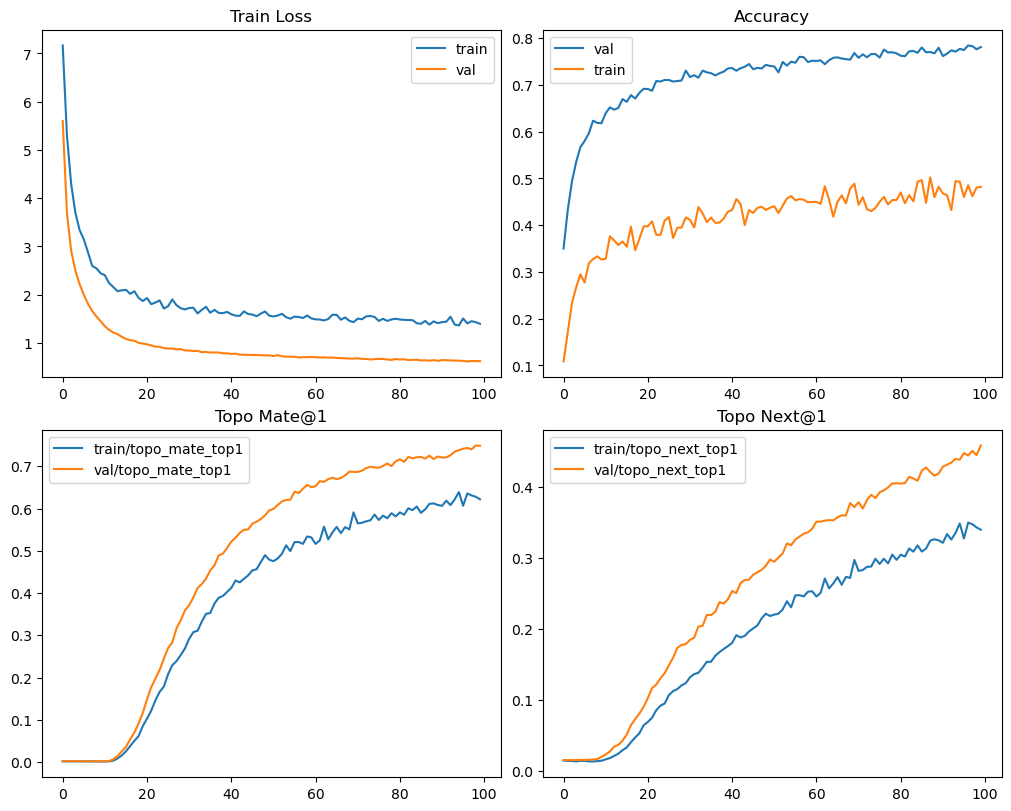

In [10]:
from src.modeling.ssl_graph_brep import plots

metrics_csv = REPORTS_DIR / "ssl_brep" / "version_0" / "metrics.csv"

plots.plot_training_curves(metrics_csv)

In [11]:
from src.modeling.ssl_graph_brep.inference import extract_embeddings, topk_similar, search_by_name

ckpt = MODELS_DIR / "ssl_brep" / "ssl-brep-epoch=96-val_infoNCE_acc=0.784.ckpt"
# BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "test" / "features" / "42. Ejector"
data_dir = Path(BREPNET_NPZ_DIR)
ids, E = extract_embeddings(ckpt, data_dir)

topk_idx = topk_similar(E, k=10)
for i, nn_idx in enumerate(topk_idx[:15]):
    print("Query:", ids[i])
    print("Top-10:", [ids[j] for j in nn_idx])
    print("---")

Query: 42. Ejector-01.prt
Top-10: ['42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector-06.prt', '42. Ejector-04.prt', '42. Ejector-10.prt', '42. Ejector-09.prt', '42. Ejector-02', '42. Ejector-03.prt', '42. Ejector.prt', '42. Ejector-08.prt']
---
Query: 42. Ejector-02
Top-10: ['42. Ejector-02', '42. Ejector-03.prt', '42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector-06.prt', '42. Ejector.prt', '42. Ejector-04.prt', '42. Ejector-10.prt', '42. Ejector-09.prt', 'Зацеп трубки направляющий 7.prt']
---
Query: 42. Ejector-03.prt
Top-10: ['42. Ejector-03.prt', '42. Ejector-02', '42. Ejector-04.prt', '42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector-06.prt', '42. Ejector-09.prt', '42. Ejector-10.prt', '42. Ejector.prt', 'Зацеп трубки направляющий 7.prt']
---
Query: 42. Ejector-04.prt
Top-10: ['42. Ejector-04.prt', '42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector-09.prt', '42. Ejector-06.prt', '42. Ejector-10.prt', '42. Ejector-03.prt', '42. Ejector-02', '42. Ejector.pr

In [14]:
# BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "test" / "features" / "Затвор"

ids, E = extract_embeddings(model_ckpt=ckpt, data_dir=BREPNET_NPZ_DIR)


results = search_by_name(ids, E, query_name="Кожух 9.prt", include_self=True, max_print=30)


Запрос: Кожух 9.prt
   1. 100.00%  Кожух 9.prt
   2.  99.97%  Кожух 10.prt
   3.  99.72%  Кожух 7.prt
   4.  99.72%  Кожух 6.prt
   5.  99.72%  Кожух 8.prt
   6.  99.43%  Кожух 1.prt
   7.  99.22%  Кожух.prt
   8.  98.44%  Защелка АК 9.prt
   9.  98.35%  Защелка.prt
  10.  98.34%  43. Extractor-03.prt
  11.  98.29%  Защелка АК 1.prt
  12.  98.27%  43. Extractor-01.prt
  13.  98.26%  Защелка АК.prt
  14.  98.26%  43. Extractor-02.prt
  15.  98.20%  Защелка АК 2.prt
  16.  98.20%  Колодка прицельная 9.prt
  17.  98.17%  43. Extractor.prt
  18.  98.10%  Защелка 4.prt
  19.  98.09%  Колодка прицельная 10.prt
  20.  98.06%  Защелка 5.prt
  21.  98.05%  Защелка 7.prt
  22.  98.05%  Защелка 6.prt
  23.  97.95%  Колодка прицельная.prt
  24.  97.94%  Колодка прицельная 7.prt
  25.  97.94%  Колодка прицельная 1.prt
  26.  97.91%  Колодка прицельная 3.prt
  27.  97.90%  Колодка прицельная 8.prt
  28.  97.89%  Колодка прицельная 5.prt
  29.  97.87%  Защелка АК 3.prt
  30.  97.87%  Колодка прицель